In [1]:
google_colab_env = False

In [ ]:
if google_colab_env:
    !pip install tensorflow=="2.0.*"

In [2]:
if google_colab_env:
    from google.colab import drive
    drive.mount('/content/drive')
    !git clone https://github.com/GrzegorzKazana/artificial-music.git

## importing dataset, splitting tracks

In [3]:
import os
import sys
import numpy as np

proj_base_path = ('/content/artificial-music' 
                  if google_colab_env else '../../../')

data_base_path =  ('/content/drive/My Drive/artificial-music/datasets'
                   if google_colab_env else '../../../datasets')

models_base_path =  ('/content/drive/My Drive/artificial-music/pretrained_models' 
                     if google_colab_env else '../../../pretrained_models')

sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_embedded_w_time/'
dataset_tracks_dir = 'w_time'
word_vectors_file = 'just_sparse/meta/_word_vectors_10000_ignore_ratio=0.05.wv'

tracks_path = os.path.join(data_base_path, dataset_path, dataset_tracks_dir)
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)

track_paths = [os.path.join(tracks_path, f) for f in os.listdir(tracks_path)]

f'found {len(track_paths)} tracks'

'found 250 tracks'

In [4]:
# load tracks
tracks = [np.load(p) for p in track_paths]

In [5]:
# load word vectors
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

In [6]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(tracks, (10, 50), 5))
x.shape, y.shape

((5, 16, 19), (5, 16, 19))

## Setting up model

In [7]:
from tensorflow import keras as K

WORD_VECTOR_SIZE = 16
REST_DATA = 3

INPUT_SIZE = WORD_VECTOR_SIZE + REST_DATA
HIDDEN_SIZE = 128
HIDDEN_DENSE = 64
OUTPUT_SIZE = INPUT_SIZE

BATCH_SIZE = 16
WINDOW_SIZE_RANGE = (10, 30)

INPUT_SHAPE = (None, INPUT_SIZE)
# None allows for variable seq_length between batches

NOTE_VECTOR_OUTPUT_NAME = 'note_vector'
REST_DATA_OUTPUT_NAME = 'rest_data'

#### load existing model

In [8]:
# or load saved model
model_path = 'lstm_lstm/embedded_16_128_stacked_32/embedded_16_128_stacked_32md_e200_t2019-10-09T09_59_31_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [9]:
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model

input_layer = Input(shape=INPUT_SHAPE)

x = LSTM(
    HIDDEN_SIZE, 
    return_sequences=True,
)(input_layer)
x = Dense(HIDDEN_DENSE)(x)

# no activation - regression task
note_vector_output = Dense(WORD_VECTOR_SIZE, name=NOTE_VECTOR_OUTPUT_NAME)(x)

# relu - encoded rest data - timing and velocity must be positive
rest_data_output = Dense(REST_DATA, activation='relu', name=REST_DATA_OUTPUT_NAME)(x)

model = Model(
    inputs=input_layer, 
    outputs=[note_vector_output, rest_data_output]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 19)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    75776       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     8256        lstm[0][0]                       
__________________________________________________________________________________________________
note_vector (Dense)             (None, None, 16)     1040        dense[0][0]                      
______________________________________________________________________________________________

In [10]:
losses = {
    NOTE_VECTOR_OUTPUT_NAME: 'mse',
    REST_DATA_OUTPUT_NAME: 'mse',
}

# balancing losses - output with less neurons needs larger weight
# so that output losses affect weights 1:1
output_weights = {
    NOTE_VECTOR_OUTPUT_NAME: (1 - WORD_VECTOR_SIZE / (WORD_VECTOR_SIZE + REST_DATA)),
    REST_DATA_OUTPUT_NAME: (1 - REST_DATA / (WORD_VECTOR_SIZE + REST_DATA)),
}

model.compile(
    loss=losses,
    loss_weights=output_weights,
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

#### define training callbacks

In [11]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

# logging callback
logging_path = 'lstm_w_time'
experiment_name = f'embedded_w_time_{INPUT_SIZE}_{HIDDEN_SIZE}'
experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
os.makedirs(experiment_path, exist_ok=True)
print(f'saving checkpoints and logs to {experiment_path}')

# logging disabled for now
log_callback = ModelAndLogSavingCallback(model, experiment_path, save_log_only=True)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.embedded_w_time_generating_seeds import seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.embedded_with_time.unembed_in_time import np2sparse

# note, that seed length refers to number of notes
# instead of number of frames
SEED_LENGTH = 10
GENERATED_SEQ_LENGTH = 100
GENERATING_WINDOW_SIZE = 10
METHOD = 'multi_note_harmonic_seed'

seed_generator = lambda: seed_generators[METHOD](
    SEED_LENGTH, WORD_VECTOR_SIZE, word_vectors=wv, batch_size=BATCH_SIZE)

sample_generator = lambda model, seed: recurrent_generate(
    model, 
    seed, 
    GENERATED_SEQ_LENGTH, 
    GENERATING_WINDOW_SIZE, 
    is_binary=False, 
    transform_output=lambda y: np.concatenate((y[0], y[1]), axis=2)
)

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    lambda batch_of_samples: [np2sparse(sample, wv) for sample in batch_of_samples]
)

print(f'generating sequences of {GENERATED_SEQ_LENGTH} using {METHOD}')

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

saving checkpoints and logs to ../../../pretrained_models/lstm_w_time/embedded_w_time_19_128
restored archived logs
generating sequences of 100 using multi_note_harmonic_seed


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint(
    os.path.join(experiment_path, 'm_e_{epoch:03d}-l_{val_loss:.2f}.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-2,
    patience=10
)

#### training

In [13]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

def split_output_gen(X, window_size_range, batch_size):
    gen = dataset_gen(X, window_size_range, batch_size)
    while True:
        x, y = next(gen)
        y_split = {
            NOTE_VECTOR_OUTPUT_NAME: y[:, :, :WORD_VECTOR_SIZE],
            REST_DATA_OUTPUT_NAME: y[:, :, -REST_DATA:],
        }
        
        yield x, y_split

data_gen = split_output_gen(tracks, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = split_output_gen(tracks, WINDOW_SIZE_RANGE, BATCH_SIZE)

Epoch 1/10
 998/1000 [============================>.] - ETA: 0s - loss: 6.4942 - note_vector_loss: 38.8318 - rest_data_loss: 0.4309 - note_vector_mean_squared_error: 38.7536 - rest_data_mean_squared_error: 0.4273

/Users/grzegorzkazana/programowanko/artificial-music/src/training/lstm_w_time/../../../src/training/common/training_callbacks.py:71: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(x_np.T[::-1, :])


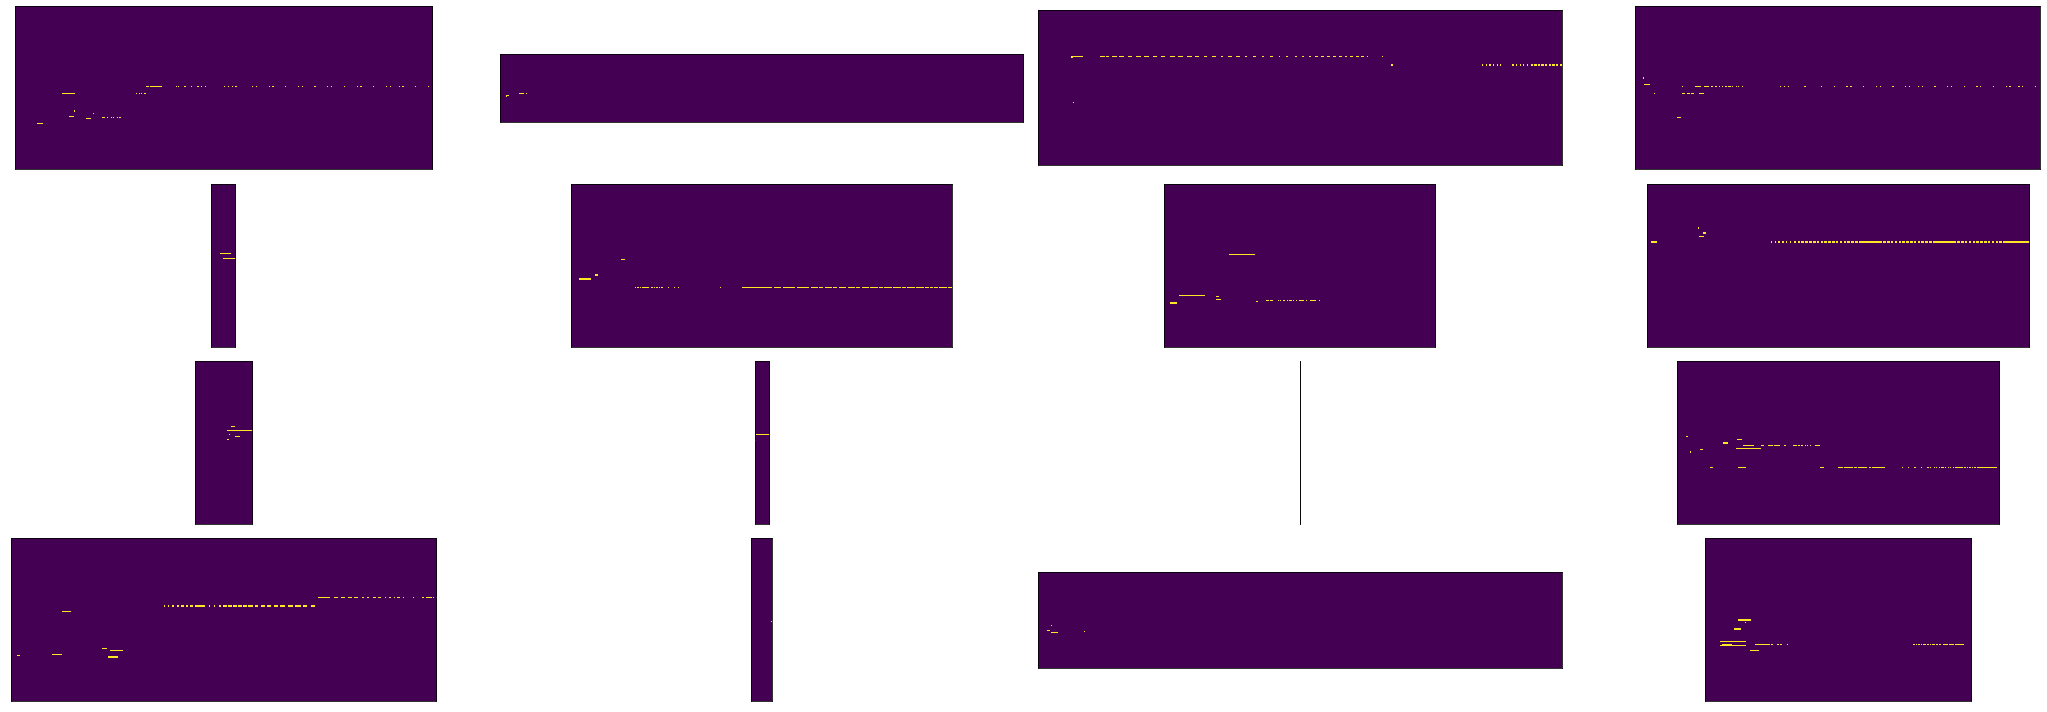

1000/1000 [==============================] - 59s 59ms/step - loss: 6.4938 - note_vector_loss: 38.8299 - rest_data_loss: 0.4307 - note_vector_mean_squared_error: 38.7512 - rest_data_mean_squared_error: 0.4271 - val_loss: 6.1527 - val_note_vector_loss: 37.0476 - val_rest_data_loss: 0.3599 - val_note_vector_mean_squared_error: 36.9251 - val_rest_data_mean_squared_error: 0.3560
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 5.9702 - note_vector_loss: 35.8818 - rest_data_loss: 0.3617 - note_vector_mean_squared_error: 35.7149 - rest_data_mean_squared_error: 0.3588

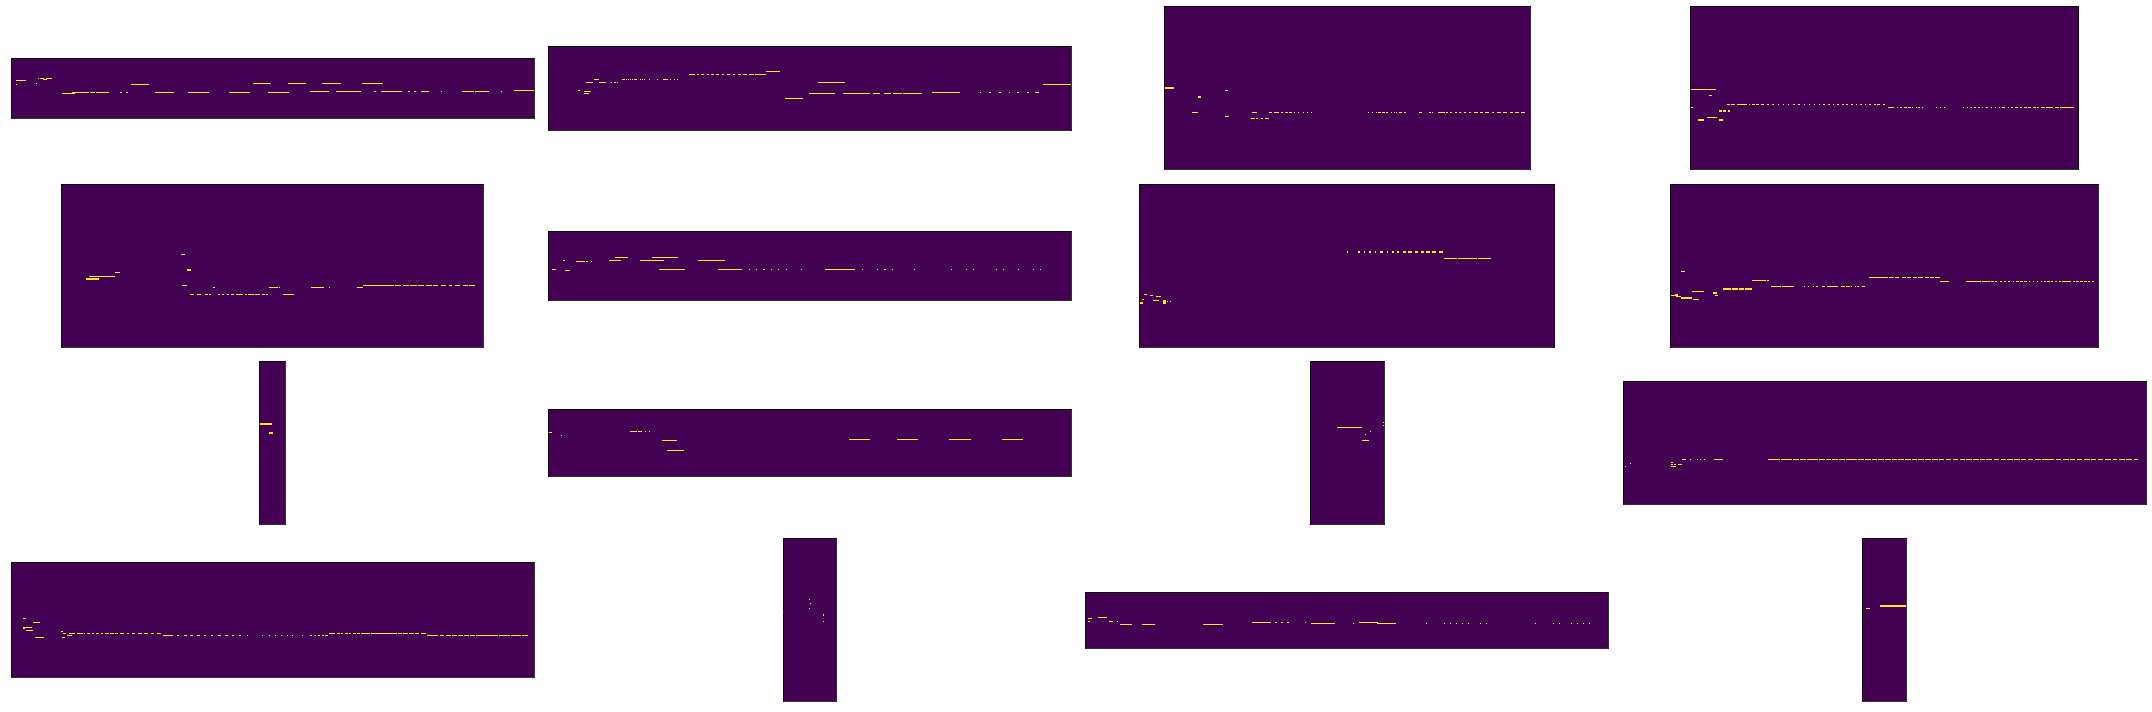

1000/1000 [==============================] - 57s 57ms/step - loss: 5.9702 - note_vector_loss: 35.8813 - rest_data_loss: 0.3619 - note_vector_mean_squared_error: 35.7146 - rest_data_mean_squared_error: 0.3589 - val_loss: 5.7756 - val_note_vector_loss: 34.6798 - val_rest_data_loss: 0.3561 - val_note_vector_mean_squared_error: 34.5343 - val_rest_data_mean_squared_error: 0.3443
Epoch 3/10
 999/1000 [============================>.] - ETA: 0s - loss: 5.6396 - note_vector_loss: 33.8939 - rest_data_loss: 0.3419 - note_vector_mean_squared_error: 33.7004 - rest_data_mean_squared_error: 0.3403

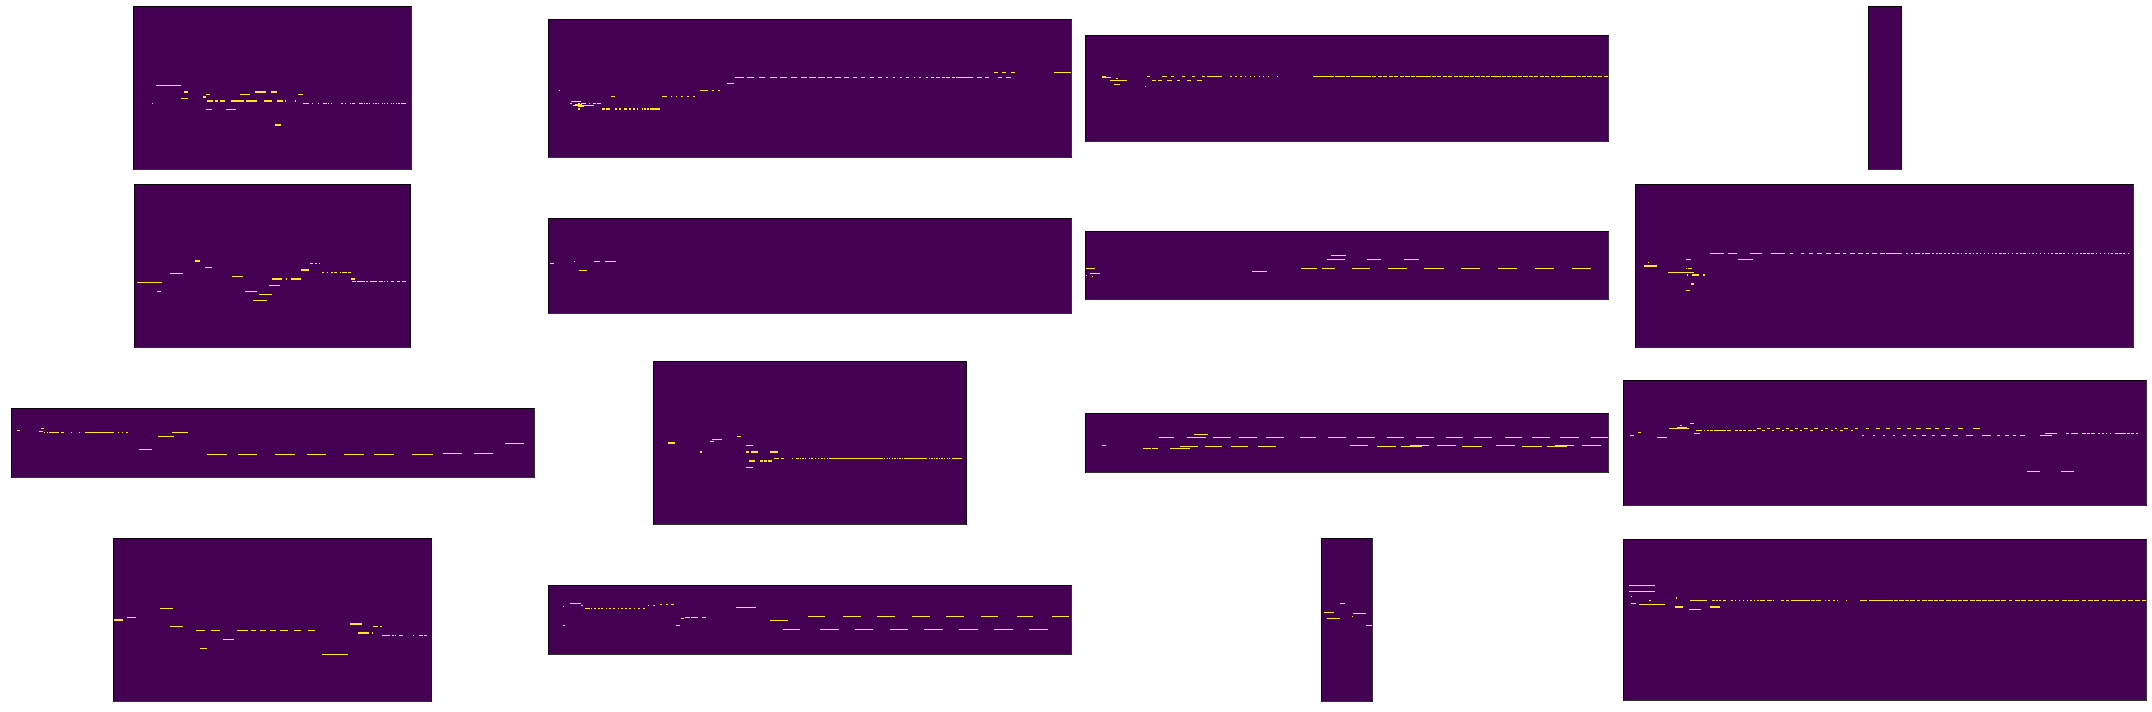

1000/1000 [==============================] - 58s 58ms/step - loss: 5.6394 - note_vector_loss: 33.8928 - rest_data_loss: 0.3419 - note_vector_mean_squared_error: 33.6996 - rest_data_mean_squared_error: 0.3403 - val_loss: 5.5696 - val_note_vector_loss: 33.4765 - val_rest_data_loss: 0.3370 - val_note_vector_mean_squared_error: 33.2639 - val_rest_data_mean_squared_error: 0.3301
Epoch 4/10
 999/1000 [============================>.] - ETA: 0s - loss: 5.4394 - note_vector_loss: 32.7480 - rest_data_loss: 0.3190 - note_vector_mean_squared_error: 32.5281 - rest_data_mean_squared_error: 0.3158

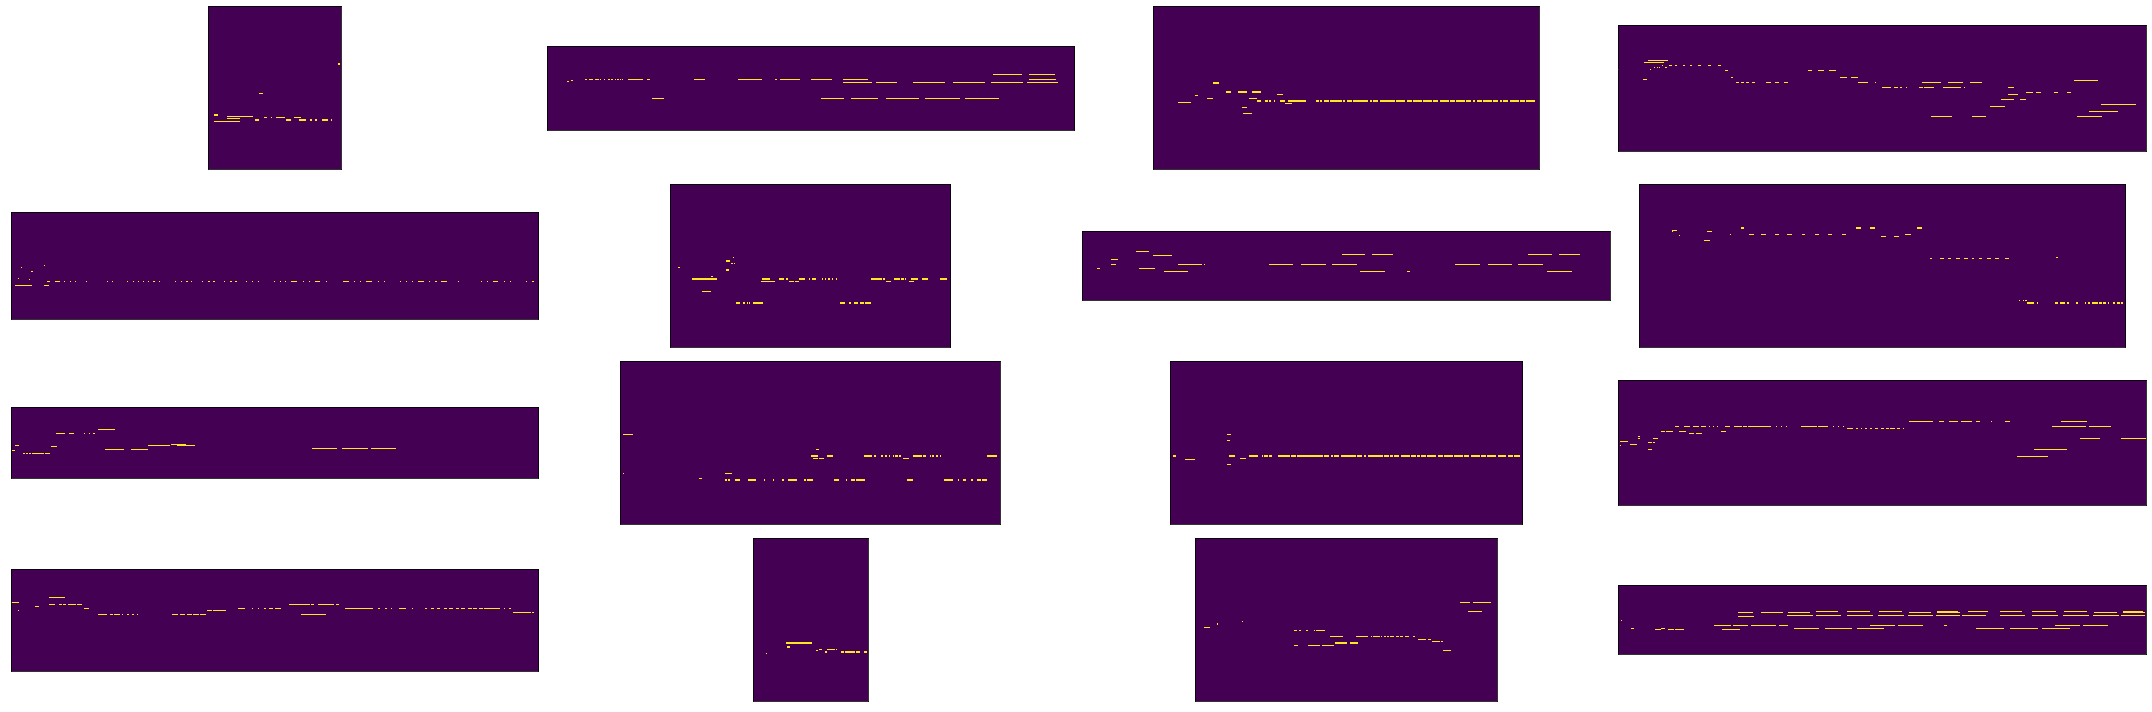

1000/1000 [==============================] - 57s 57ms/step - loss: 5.4389 - note_vector_loss: 32.7456 - rest_data_loss: 0.3189 - note_vector_mean_squared_error: 32.5252 - rest_data_mean_squared_error: 0.3157 - val_loss: 5.3035 - val_note_vector_loss: 32.0825 - val_rest_data_loss: 0.2824 - val_note_vector_mean_squared_error: 31.8496 - val_rest_data_mean_squared_error: 0.2698
Epoch 5/10
 998/1000 [============================>.] - ETA: 0s - loss: 5.2743 - note_vector_loss: 31.8576 - rest_data_loss: 0.2900 - note_vector_mean_squared_error: 31.6249 - rest_data_mean_squared_error: 0.2863

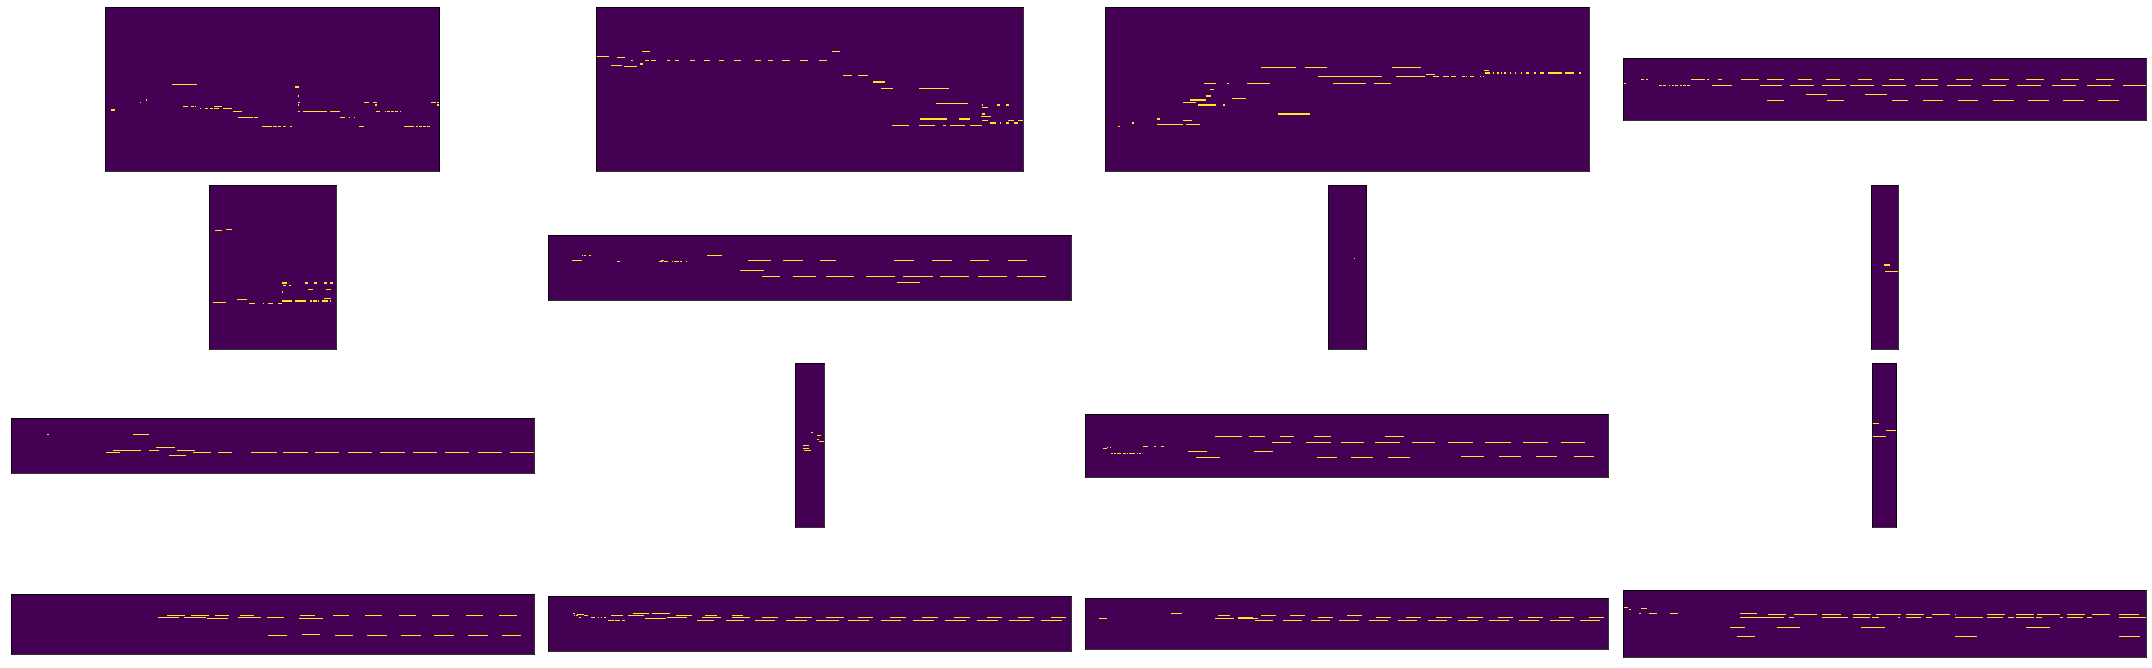

1000/1000 [==============================] - 57s 57ms/step - loss: 5.2743 - note_vector_loss: 31.8568 - rest_data_loss: 0.2901 - note_vector_mean_squared_error: 31.6247 - rest_data_mean_squared_error: 0.2864 - val_loss: 5.1467 - val_note_vector_loss: 31.0840 - val_rest_data_loss: 0.2835 - val_note_vector_mean_squared_error: 30.8621 - val_rest_data_mean_squared_error: 0.2887
Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 5.1115 - note_vector_loss: 30.8930 - rest_data_loss: 0.2775 - note_vector_mean_squared_error: 30.6196 - rest_data_mean_squared_error: 0.2740

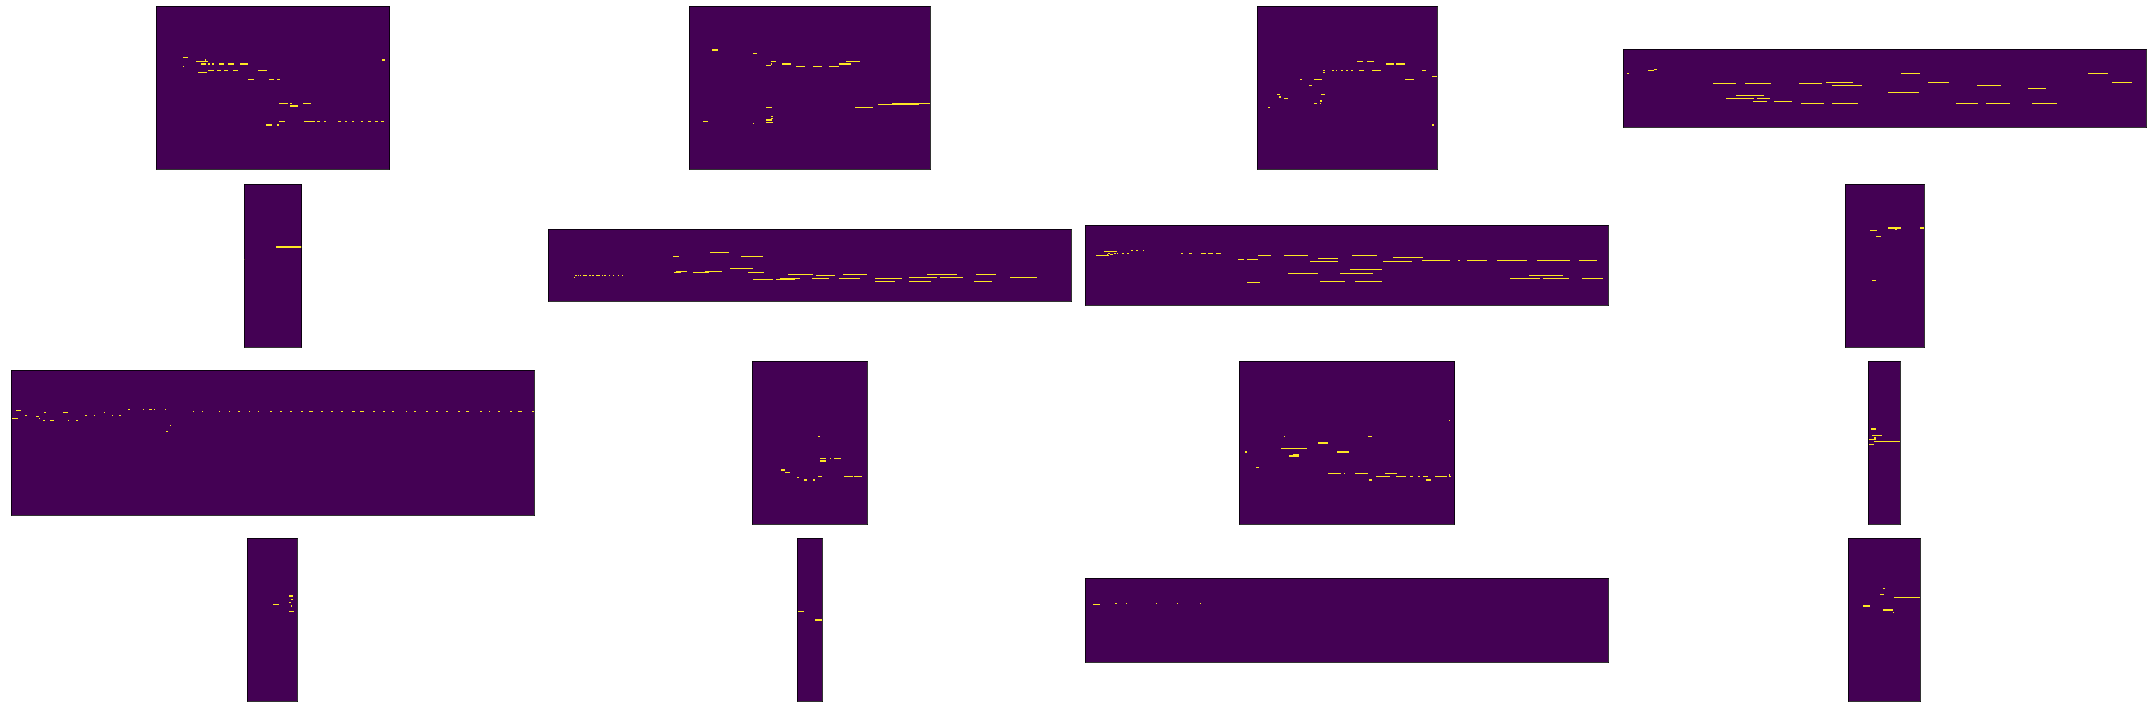

1000/1000 [==============================] - 58s 58ms/step - loss: 5.1119 - note_vector_loss: 30.8935 - rest_data_loss: 0.2779 - note_vector_mean_squared_error: 30.6204 - rest_data_mean_squared_error: 0.2743 - val_loss: 5.0883 - val_note_vector_loss: 30.7583 - val_rest_data_loss: 0.2751 - val_note_vector_mean_squared_error: 30.3299 - val_rest_data_mean_squared_error: 0.2785
Epoch 7/10
 999/1000 [============================>.] - ETA: 0s - loss: 4.9862 - note_vector_loss: 30.1325 - rest_data_loss: 0.2713 - note_vector_mean_squared_error: 29.8751 - rest_data_mean_squared_error: 0.2664

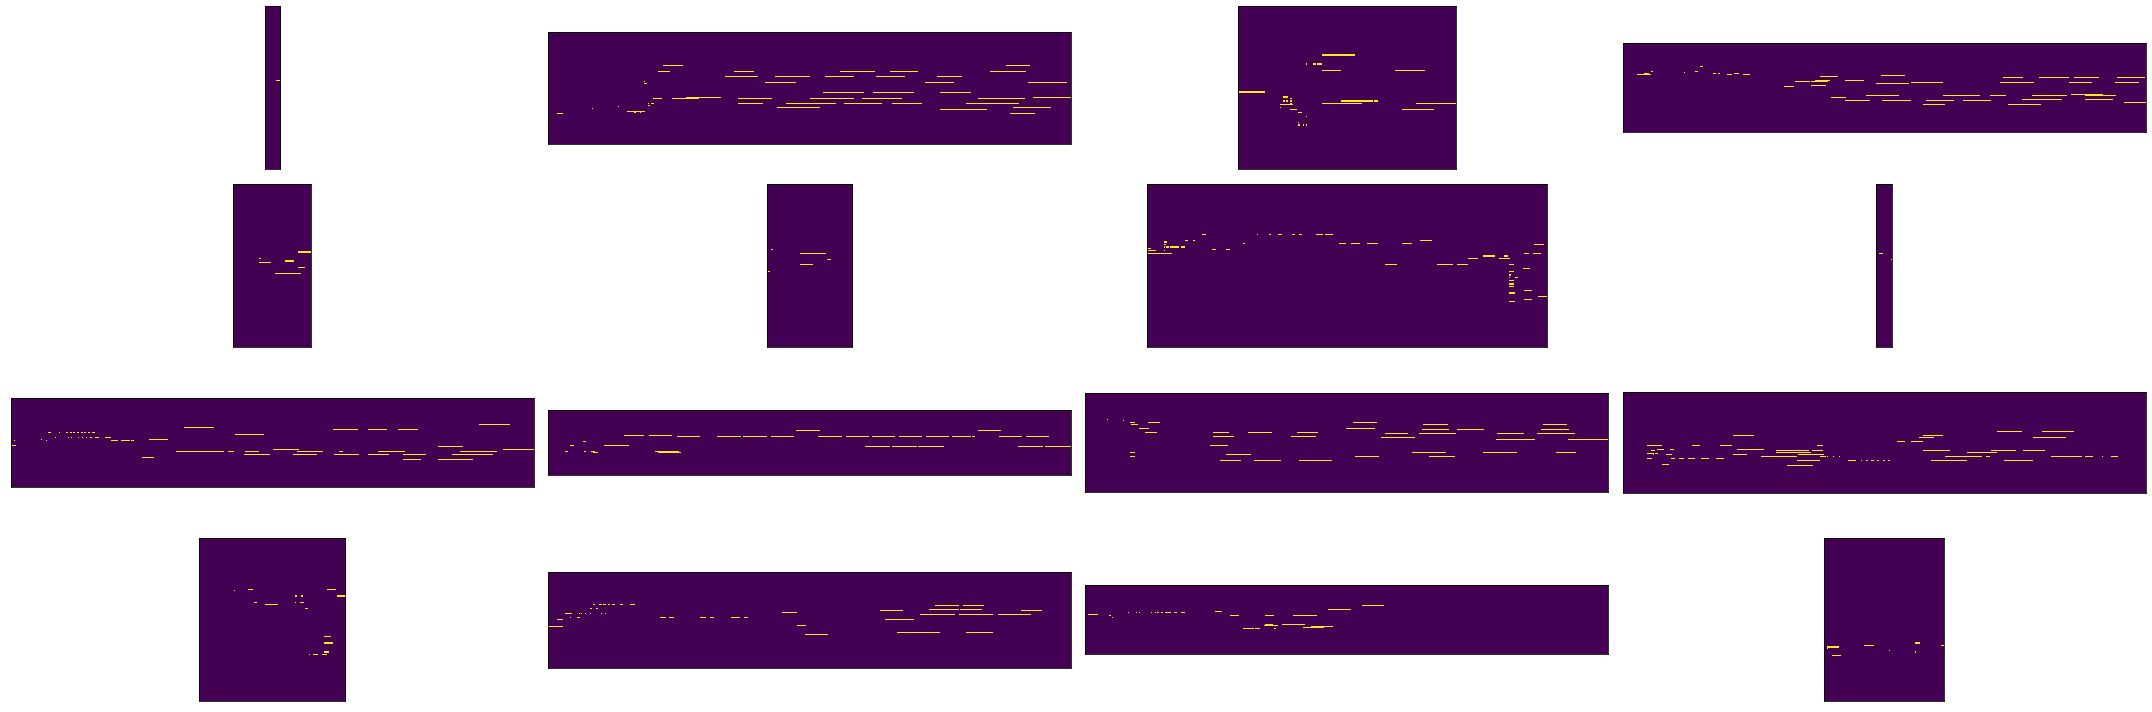

1000/1000 [==============================] - 60s 60ms/step - loss: 4.9871 - note_vector_loss: 30.1388 - rest_data_loss: 0.2711 - note_vector_mean_squared_error: 29.8785 - rest_data_mean_squared_error: 0.2663 - val_loss: 4.9259 - val_note_vector_loss: 29.7665 - val_rest_data_loss: 0.2683 - val_note_vector_mean_squared_error: 29.3651 - val_rest_data_mean_squared_error: 0.2650
Epoch 8/10
 999/1000 [============================>.] - ETA: 0s - loss: 4.9295 - note_vector_loss: 29.7891 - rest_data_loss: 0.2684 - note_vector_mean_squared_error: 29.4875 - rest_data_mean_squared_error: 0.2631

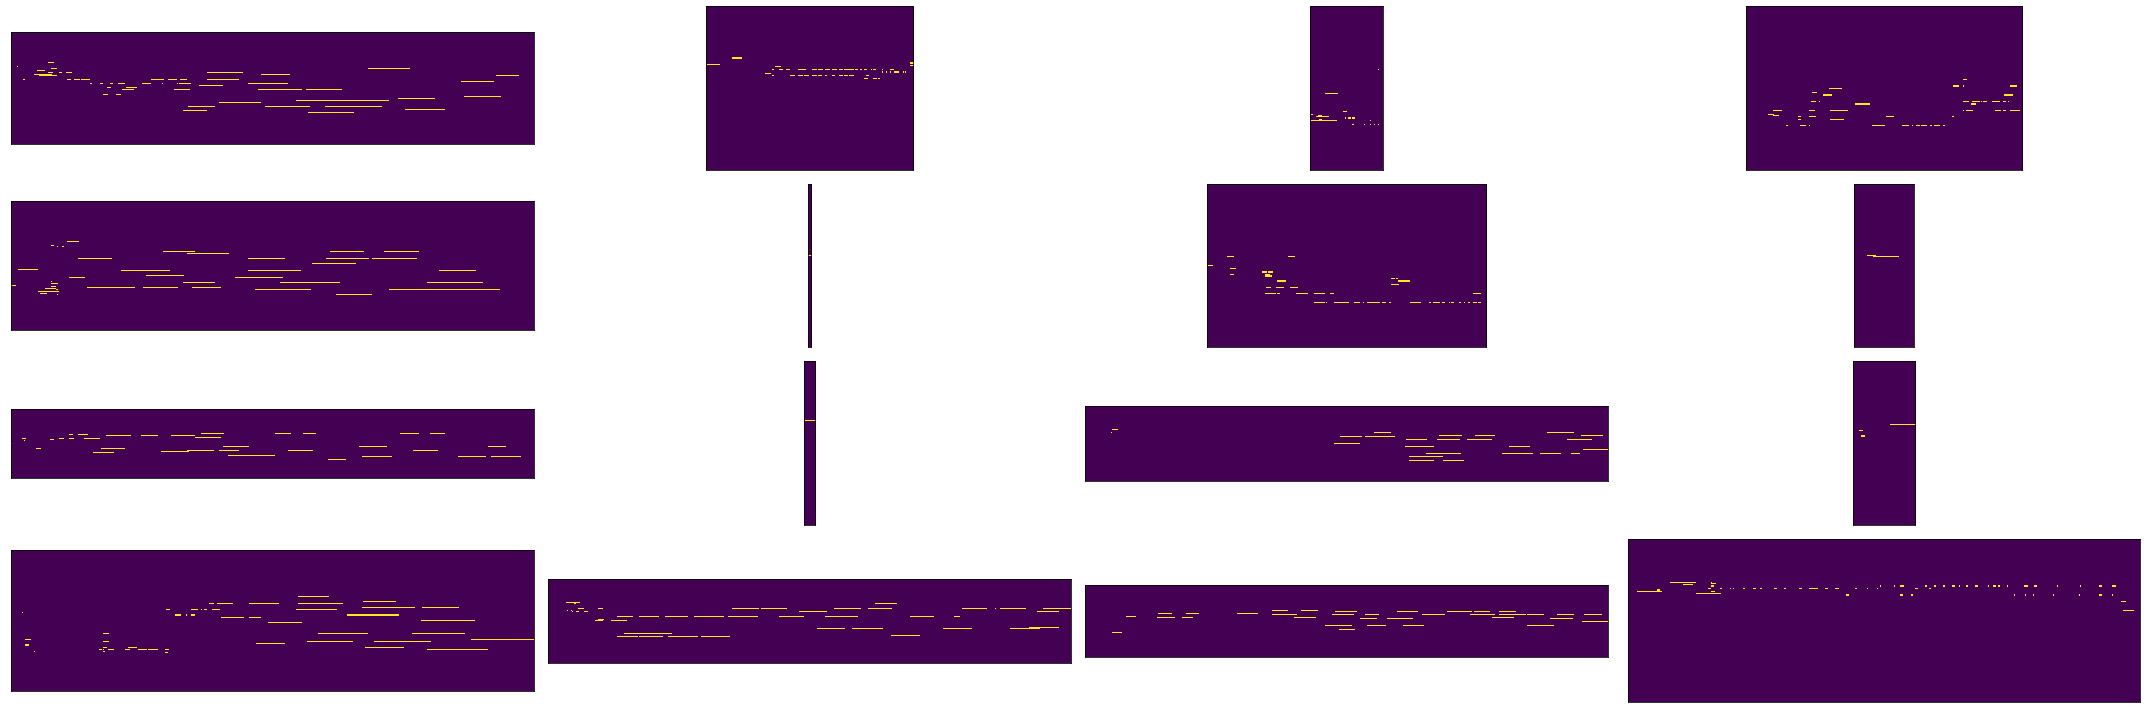

1000/1000 [==============================] - 56s 56ms/step - loss: 4.9298 - note_vector_loss: 29.7893 - rest_data_loss: 0.2686 - note_vector_mean_squared_error: 29.4878 - rest_data_mean_squared_error: 0.2633 - val_loss: 4.8912 - val_note_vector_loss: 29.5277 - val_rest_data_loss: 0.2719 - val_note_vector_mean_squared_error: 29.0946 - val_rest_data_mean_squared_error: 0.2577
Epoch 9/10
 999/1000 [============================>.] - ETA: 0s - loss: 4.8242 - note_vector_loss: 29.1426 - rest_data_loss: 0.2645 - note_vector_mean_squared_error: 28.8642 - rest_data_mean_squared_error: 0.2610

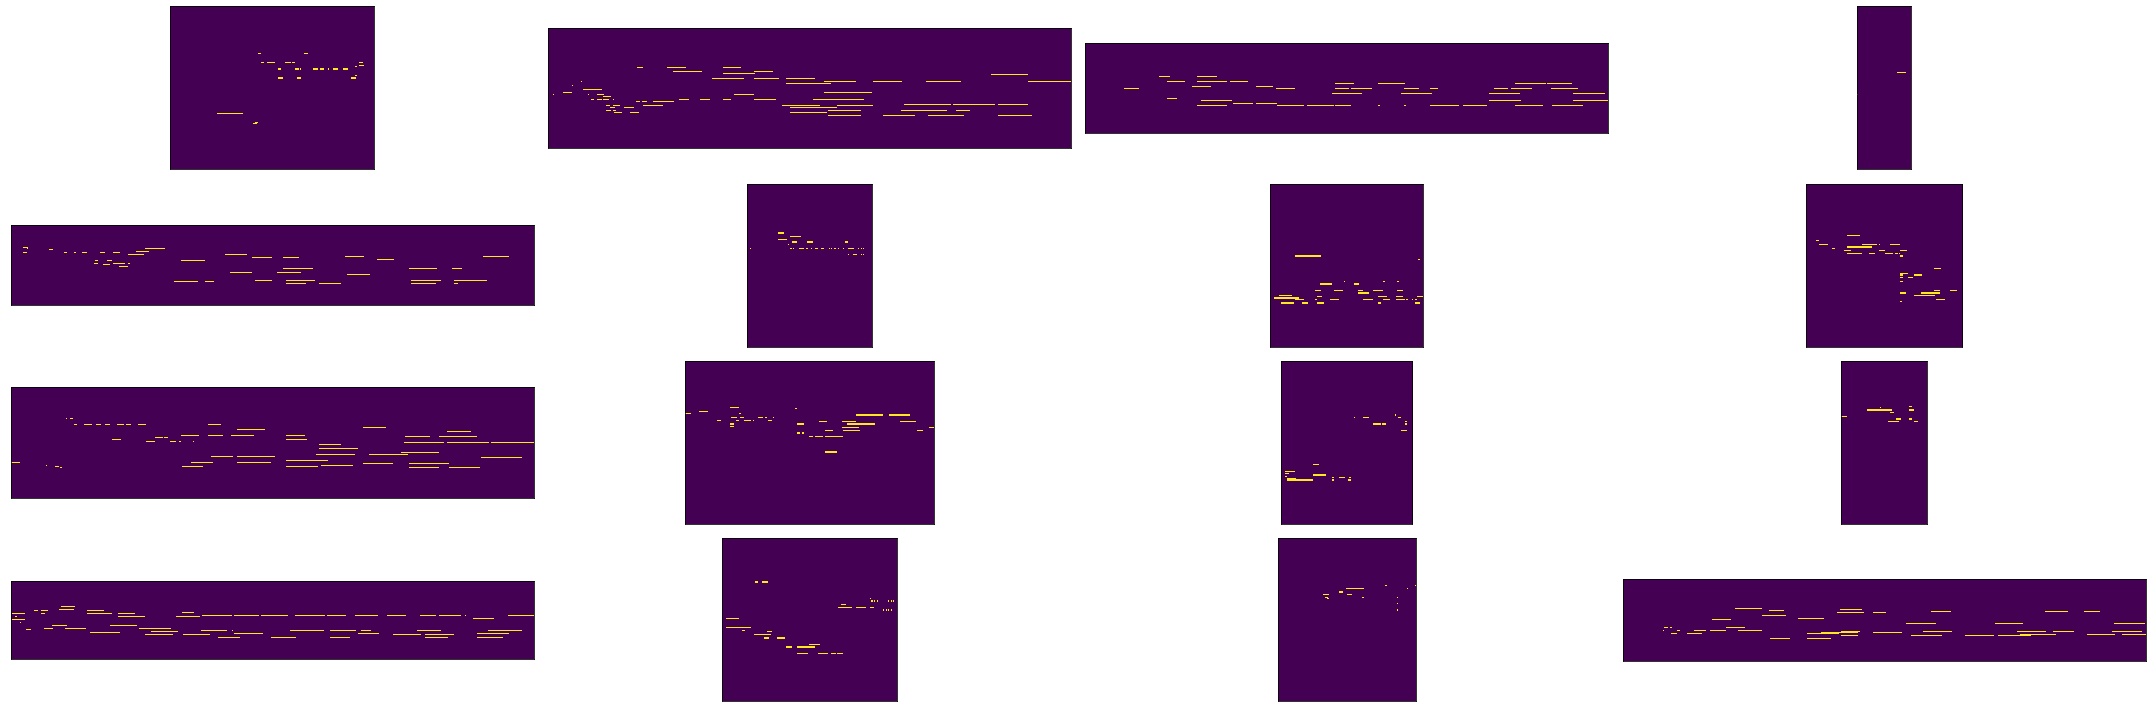

1000/1000 [==============================] - 57s 57ms/step - loss: 4.8243 - note_vector_loss: 29.1431 - rest_data_loss: 0.2645 - note_vector_mean_squared_error: 28.8649 - rest_data_mean_squared_error: 0.2609 - val_loss: 4.7838 - val_note_vector_loss: 28.8530 - val_rest_data_loss: 0.2708 - val_note_vector_mean_squared_error: 28.4993 - val_rest_data_mean_squared_error: 0.2662
Epoch 10/10
 999/1000 [============================>.] - ETA: 0s - loss: 4.7456 - note_vector_loss: 28.6851 - rest_data_loss: 0.2569 - note_vector_mean_squared_error: 28.3991 - rest_data_mean_squared_error: 0.2526

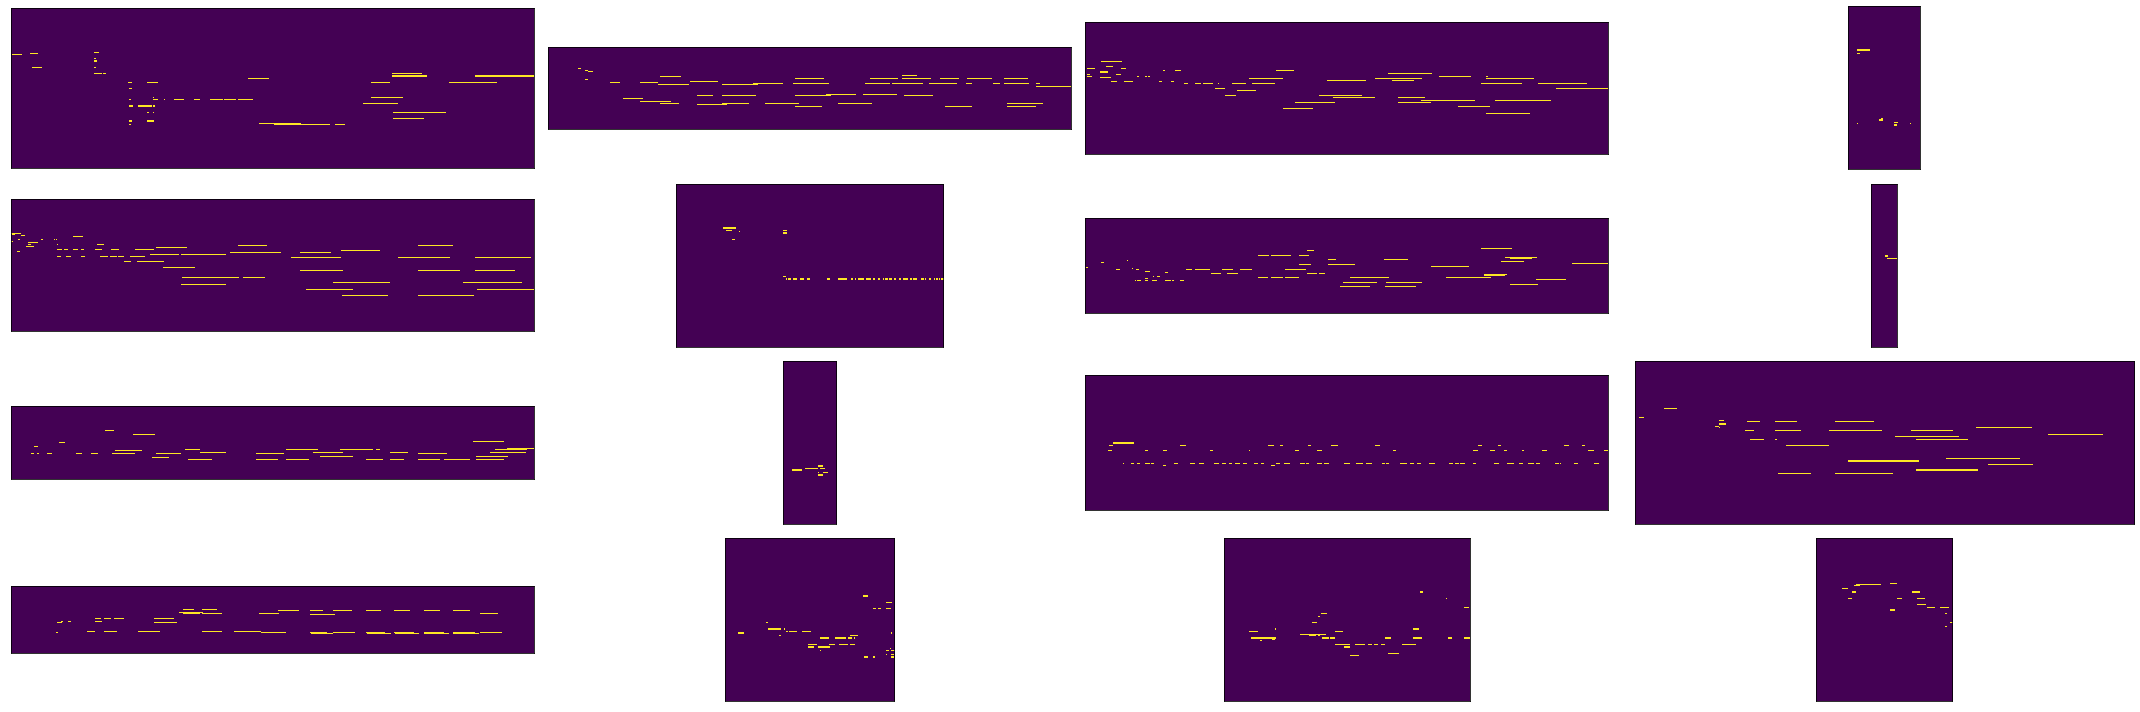

1000/1000 [==============================] - 58s 58ms/step - loss: 4.7456 - note_vector_loss: 28.6851 - rest_data_loss: 0.2569 - note_vector_mean_squared_error: 28.3993 - rest_data_mean_squared_error: 0.2526 - val_loss: 4.6956 - val_note_vector_loss: 28.4105 - val_rest_data_loss: 0.2490 - val_note_vector_mean_squared_error: 28.1336 - val_rest_data_mean_squared_error: 0.2435


In [15]:
EPOCHS = 10
STEPS_PER_EPOCH = 1000
TEST_STEPS = 100

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback, mc, es]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS